# Import packages

In [616]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf
import pandas as pd
import math

from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from random import random

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# Set figure parameters
plt.rcParams['figure.figsize'] = [10, 7.5]

# Input datasets

[*********************100%%**********************]  1 of 1 completed


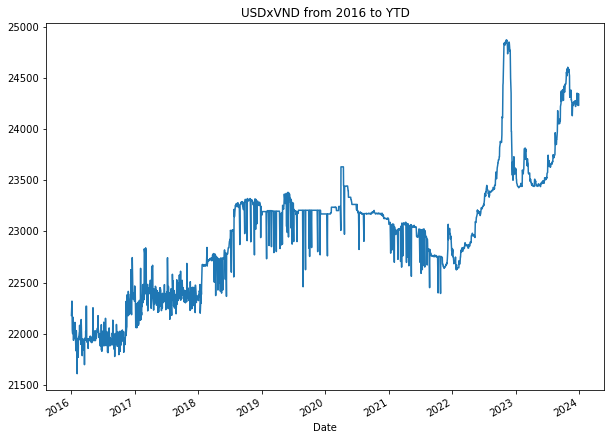

In [617]:
# Get data
data = yf.download('USDVND=X','2016-01-01','2024-01-01') # from 1 Jan 2021 to 31 December 2022

# Plot
data['Adj Close'].plot()
plt.title("USDxVND from 2016 to YTD")
plt.show()


# Stationarity

ADF Test Results
Null Hypothesis: The series has a unit root (non-stationary)
ADF-Statistic: -2.788486879363325
P-Value: 0.20120523655901873
Number of lags: 15
Number of observations: 2069
Critical Values: {'1%': -3.9631522480957244, '5%': -3.4126141072627973, '10%': -3.1283006052584623}
Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary


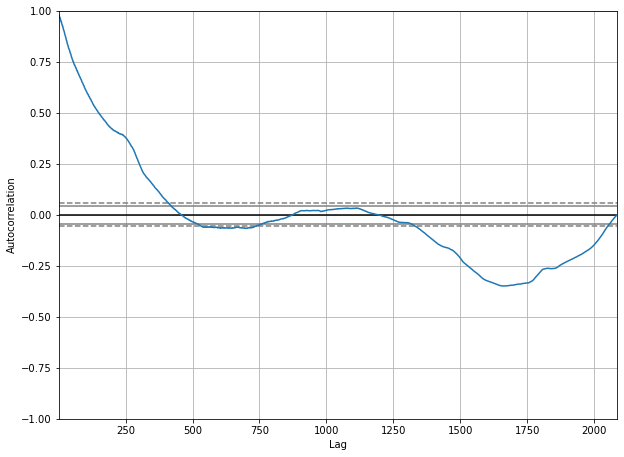

In [618]:
# Check autocorrelation
df = pd.DataFrame(data['Adj Close']) 
autocorrelation_plot(df)

# Check adf
adftest = adfuller(df, autolag='AIC', regression='ct')
print("ADF Test Results")
print("Null Hypothesis: The series has a unit root (non-stationary)")
print("ADF-Statistic:", adftest[0])
print("P-Value:", adftest[1])
print("Number of lags:", adftest[2])
print("Number of observations:", adftest[3])
print("Critical Values:", adftest[4])
print("Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary")

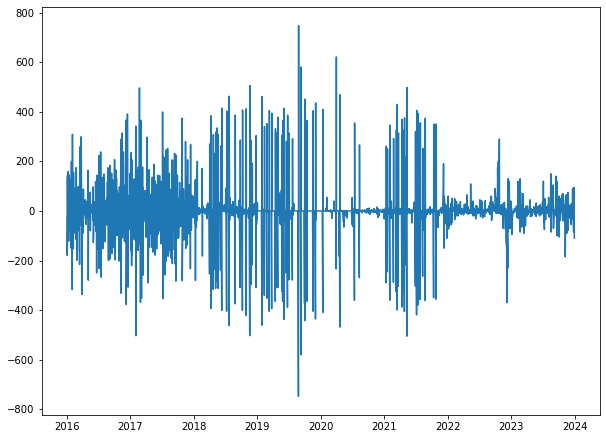

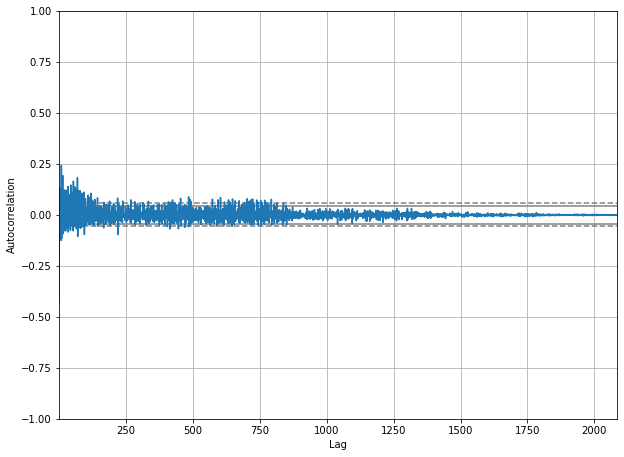

ADF Test Results
Null Hypothesis: The series has a unit root (non-stationary)
ADF-Statistic: -12.24622732471399
P-Value: 1.5711729386828928e-19
Number of lags: 14
Number of observations: 2069
Critical Values: {'1%': -3.9631522480957244, '5%': -3.4126141072627973, '10%': -3.1283006052584623}
Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary


In [619]:
# Apply first order difference
df['diff1'] = df['Adj Close'].diff().dropna()

# line plot
plt.plot(df['diff1'])
plt.show()

autocorrelation_plot(df['diff1'].dropna())
plt.show()

# Check adf
adftest = adfuller(df['diff1'].dropna(), autolag='AIC', regression='ct')
print("ADF Test Results")
print("Null Hypothesis: The series has a unit root (non-stationary)")
print("ADF-Statistic:", adftest[0])
print("P-Value:", adftest[1])
print("Number of lags:", adftest[2])
print("Number of observations:", adftest[3])
print("Critical Values:", adftest[4])
print("Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary")

# Forecast

In [628]:
# Find average 
df_avg = sum(abs(df['diff1'].dropna()))/len(df)

In [629]:
# Separate data into train and test data
df = df.reset_index()
msk = (df.index < len(df)*0.66)
df_train_diff = df['diff1'][msk].copy().dropna()
df_train = pd.DataFrame(df[{'Adj Close','Date'}][msk].copy())
df_test_diff = df['diff1'][~msk].copy().dropna()
df_test = df[{'Adj Close','Date'}][~msk].copy()
df.set_index("Date", inplace=True)

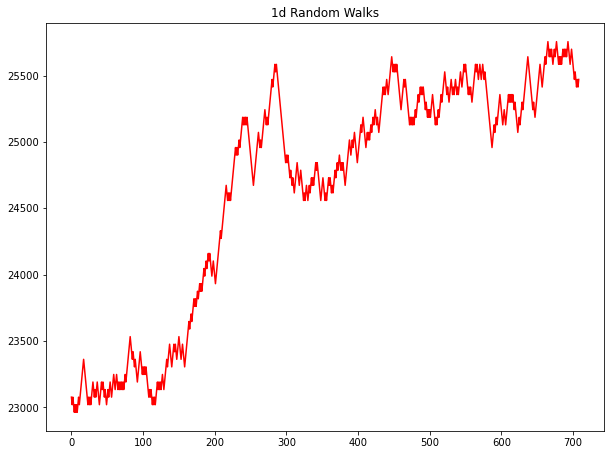

In [630]:
def Randomwalk1d(n):
    x = 0
    y = df_test['Adj Close'].iloc[1]
    xposition = [0]
    yposition = [y]
    
    for i in range (0,n):
        step = np.random.uniform(0,1)
        if step < 0.5:
            x=x+1
            y = y + df_avg
        if step > 0.5:
            x = x+1
            y = y - df_avg
        if y < 0:
            y = 0
            
        xposition.append(x)
        yposition.append(y)
    return [xposition, yposition]

Randwalk = Randomwalk1d(len(df_test))

plt.plot(Randwalk[0],Randwalk[1],'r-', label = "RandWalk1d")
plt.title('1d Random Walks')
plt.show()


In [631]:
yhat = Randwalk[1]
yhat = yhat[1:]
yhat = pd.DataFrame(yhat)

In [632]:
# Reset index
df_test = pd.DataFrame(df_test)
df_test = df_test.reset_index()

In [633]:
# Compare actual to predicted
df_comp = pd.DataFrame(df_test)
df_comp.rename(columns={"Adj Close": "Actual"}, inplace=True)
df_comp['Predict'] = yhat[0]
df_comp.set_index("Date", inplace=True)
df_train.set_index("Date", inplace=True)

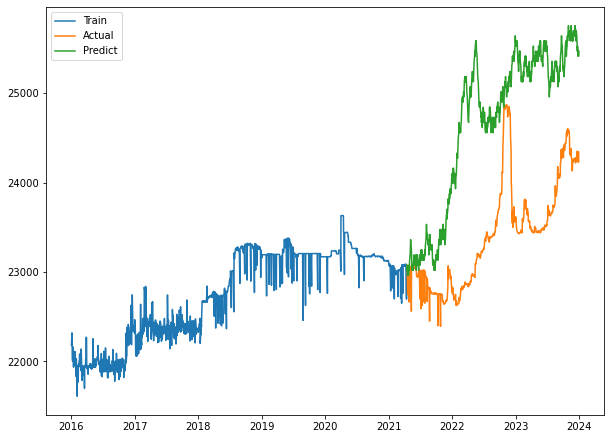

In [634]:
# Plot
dd = np.asarray(df_train)
plt.plot(df_train.index, df_train.values, label = 'Train')
plt.plot(df_comp.index,df_comp['Actual'], label = 'Actual')
plt.plot(df_comp.index,df_comp['Predict'], label = 'Predict')
plt.legend(loc='best')
plt.show()

In [635]:
# Calculate errors
mse = np.square(np.subtract(df_comp['Actual'], df_comp['Predict'])).mean()
print('mse',mse)
rmse = math.sqrt(mse)
print('rmse',rmse)

mse 1965185.5771838971
rmse 1401.8507685142156
